# 使用 Keras 進行花朵辨識
本範例輸出期末考的 CNN baseline 預測, 提供同學參考

In [1]:
# 先來看看訓練資料下有那些目錄吧
import os
train_path = '../input/train/'
test_path = '../input/test/'
print(os.listdir(train_path))

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


# 1. 載入套件

In [2]:
# 載入基礎套件
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 繪圖設定
from matplotlib import style
%matplotlib inline  
style.use('fivethirtyeight')

# 設定忽略警告訊息
import warnings
warnings.filterwarnings('ignore')

In [3]:
# 載入 Keras 預處理套件 - ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator

# 載入 Keras 其他深度學習套件
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Flatten, Activation, Conv2D, MaxPooling2D
from keras.optimizers import Adam
#from keras.callbacks import ReduceLROnPlateau # 作用 : 當監控的目標值停止改善時, 開始降低學習速率
from keras.utils import to_categorical # Keras 做 One Hot Encoding 的函數

Using TensorFlow backend.


In [4]:
# 其他相關套件    
import tensorflow as tf
import random as rn
import cv2 
from tqdm import tqdm # 進度條顯示套件  

# 2. 資料預處理

In [5]:
# 初始化 Array, 並設定讀取路徑等參數
X_train = []
y_train = []
X_test = []
id_test = []
IMG_SIZE = 150

# 設定花朵名稱對應的類別碼
flower_mapping = {'daisy':0, 'dandelion':1, 'rose':2, 'sunflower':3, 'tulip':4}
flowers = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [6]:
# 定義讀取資料的函數, 將圖檔資料讀取到輸入用的 Array 之中
def make_train_data(flower_type):
    dir_path = f'{train_path}{flower_type}/'
    for img in tqdm(os.listdir(dir_path)):
        y_train.append(str(flower_mapping[flower_type]))
        path = os.path.join(dir_path, img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))        
        X_train.append(np.array(img))  
def make_test_data():
    dir_path = test_path
    for img in tqdm(os.listdir(dir_path)):
        id_test.append(img[:-4])
        path = os.path.join(dir_path, img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))        
        X_test.append(np.array(img))

In [7]:
# 載入訓練資料
for flower in flowers:
    make_train_data(flower)
    print(f'Loading {flower} pictures, X_train length : {len(X_train)}')

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 548.39it/s]


Loading daisy pictures, X_train length : 500


100%|███████████████████████████████████████████████████████████████████████████████| 687/687 [00:01<00:00, 512.88it/s]


Loading dandelion pictures, X_train length : 1187


100%|███████████████████████████████████████████████████████████████████████████████| 515/515 [00:00<00:00, 557.14it/s]


Loading rose pictures, X_train length : 1702


100%|███████████████████████████████████████████████████████████████████████████████| 488/488 [00:01<00:00, 461.68it/s]


Loading sunflower pictures, X_train length : 2190


100%|███████████████████████████████████████████████████████████████████████████████| 633/633 [00:01<00:00, 514.48it/s]


Loading tulip pictures, X_train length : 2823


In [8]:
# 載入測試資料
make_test_data()
print(len(X_test))

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:03<00:00, 592.58it/s]


2000


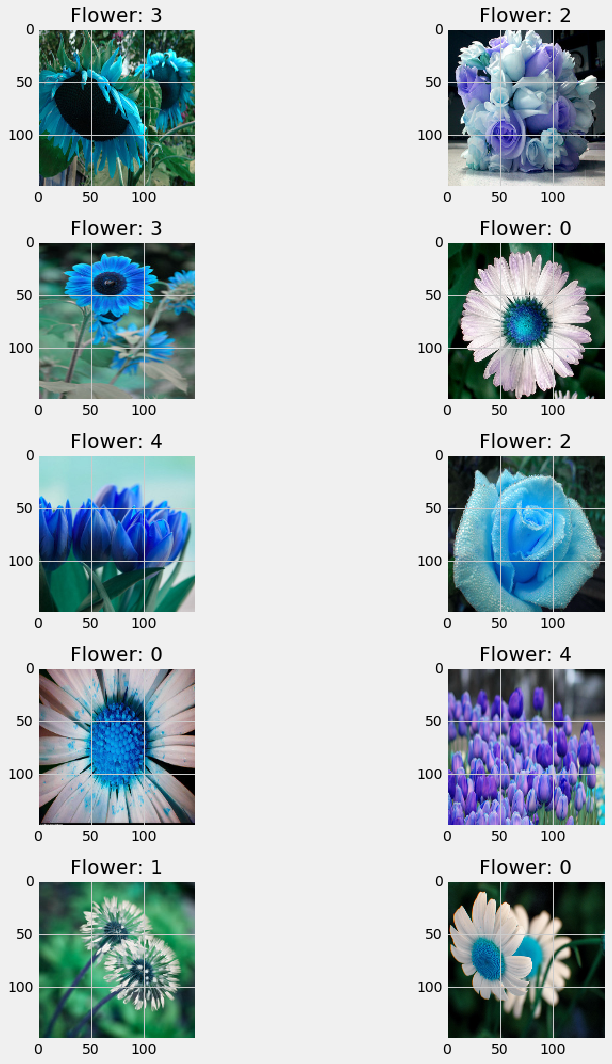

In [9]:
# 隨機顯示 10 張花朵圖案, 確認資料無誤且載入無誤
fig, ax = plt.subplots(5, 2)
fig.set_size_inches(15, 15)
for i in range(5):
    for j in range (2):
        l = rn.randint(0, len(y_train))
        ax[i, j].imshow(X_train[l])
        ax[i, j].set_title('Flower: '+ y_train[l])        
plt.tight_layout()

In [10]:
# 將影像特徵最大最小化 (除以255), 並將類別標籤做獨熱編碼 (One-Hot Encoding)
X_train = np.array(X_train)
X_train = X_train / 255
y_train = to_categorical(y_train,5)
X_test = np.array(X_test)
X_test = X_test / 255

# 設定隨機亂數種子
np.random.seed(123)
rn.seed(123)
tf.set_random_seed(123)

# 3. 設定模型與運算

In [11]:
# 使用 Keras Sequential 定義一個 CNN 模型
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5, 5),padding = 'Same',activation ='relu', input_shape = (150, 150, 3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(filters = 96, kernel_size = (3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(filters = 96, kernel_size = (3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(5, activation = "softmax"))

In [12]:
# 設定參數並使用 Keras 的 Callback 函數 - ReduceLROnPlateau
batch_size = 64
epochs = 50
#red_lr = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.1)

In [13]:
# 設定 Image Generator
datagen = ImageDataGenerator(
        featurewise_center=False,  # 是否將每個點的平均值歸 0
        samplewise_center=False,  # 是否將每張圖的平均值歸 0
        featurewise_std_normalization=False,  # 是否除以每個點的標準差
        samplewise_std_normalization=False,  # 是否除以每張圖的標準差
        rotation_range=10,  # 隨機旋轉角度的上限 (角度值 : 0 ~ 180)
        zoom_range = 0.1, # 影像倍率放大縮小的上限
        width_shift_range=0.2,  # 左右隨機平移上限
        height_shift_range=0.2,  # 上下隨機平移上限
        horizontal_flip=True,  # 是否左右翻轉
        vertical_flip=False)  # 是否上下翻轉
datagen.fit(X_train)

In [14]:
# 設定模型目標函數, 並顯示模型摘要
model.compile(optimizer = Adam(lr = 0.001),loss = 'categorical_crossentropy',metrics = ['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 150, 150, 32)      2432      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 37, 37, 96)        55392     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 18, 18, 96)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 18, 18, 96)        83040     
__________

In [15]:
# 訓練模型,並記錄訓練集的 loss 與 Accuracy
History = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size), verbose = 1,
                              epochs = epochs, steps_per_epoch = X_train.shape[0] // batch_size)

Epoch 1/50
44/44 [==============================] - ETA: 2:30 - loss: 1.6180 - acc: 0.171 - ETA: 1:14 - loss: 1.6334 - acc: 0.171 - ETA: 49s - loss: 1.6414 - acc: 0.166 - ETA: 36s - loss: 1.6365 - acc: 0.16 - ETA: 28s - loss: 1.6285 - acc: 0.19 - ETA: 23s - loss: 1.6241 - acc: 0.20 - ETA: 20s - loss: 1.6173 - acc: 0.22 - ETA: 17s - loss: 1.6156 - acc: 0.21 - ETA: 15s - loss: 1.6063 - acc: 0.23 - ETA: 13s - loss: 1.5978 - acc: 0.24 - ETA: 12s - loss: 1.5927 - acc: 0.24 - ETA: 10s - loss: 1.5794 - acc: 0.25 - ETA: 9s - loss: 1.5741 - acc: 0.2620 - ETA: 9s - loss: 1.5586 - acc: 0.271 - ETA: 8s - loss: 1.5563 - acc: 0.274 - ETA: 8s - loss: 1.5558 - acc: 0.270 - ETA: 7s - loss: 1.5417 - acc: 0.274 - ETA: 7s - loss: 1.5422 - acc: 0.284 - ETA: 6s - loss: 1.5389 - acc: 0.285 - ETA: 6s - loss: 1.5269 - acc: 0.288 - ETA: 6s - loss: 1.5274 - acc: 0.292 - ETA: 6s - loss: 1.5240 - acc: 0.290 - ETA: 5s - loss: 1.5171 - acc: 0.291 - ETA: 5s - loss: 1.5095 - acc: 0.298 - ETA: 5s - loss: 1.5076 - acc: 

44/44 [==============================] - ETA: 9s - loss: 1.0086 - acc: 0.593 - ETA: 9s - loss: 0.9664 - acc: 0.585 - ETA: 9s - loss: 1.0310 - acc: 0.552 - ETA: 9s - loss: 0.9951 - acc: 0.578 - ETA: 9s - loss: 0.9632 - acc: 0.600 - ETA: 9s - loss: 0.9776 - acc: 0.609 - ETA: 8s - loss: 0.9645 - acc: 0.622 - ETA: 8s - loss: 0.9795 - acc: 0.615 - ETA: 8s - loss: 0.9771 - acc: 0.621 - ETA: 8s - loss: 0.9663 - acc: 0.623 - ETA: 7s - loss: 0.9524 - acc: 0.627 - ETA: 7s - loss: 0.9352 - acc: 0.639 - ETA: 7s - loss: 0.9254 - acc: 0.643 - ETA: 7s - loss: 0.9274 - acc: 0.639 - ETA: 6s - loss: 0.9247 - acc: 0.640 - ETA: 6s - loss: 0.9244 - acc: 0.643 - ETA: 6s - loss: 0.9339 - acc: 0.636 - ETA: 6s - loss: 0.9364 - acc: 0.638 - ETA: 5s - loss: 0.9373 - acc: 0.645 - ETA: 5s - loss: 0.9326 - acc: 0.644 - ETA: 4s - loss: 0.9310 - acc: 0.645 - ETA: 4s - loss: 0.9316 - acc: 0.645 - ETA: 4s - loss: 0.9324 - acc: 0.645 - ETA: 4s - loss: 0.9322 - acc: 0.644 - ETA: 4s - loss: 0.9346 - acc: 0.638 - ETA: 3s -

44/44 [==============================] - ETA: 9s - loss: 0.8033 - acc: 0.703 - ETA: 9s - loss: 0.7425 - acc: 0.734 - ETA: 9s - loss: 0.7496 - acc: 0.713 - ETA: 9s - loss: 0.7808 - acc: 0.699 - ETA: 9s - loss: 0.8103 - acc: 0.681 - ETA: 9s - loss: 0.8022 - acc: 0.684 - ETA: 8s - loss: 0.8256 - acc: 0.687 - ETA: 8s - loss: 0.8305 - acc: 0.683 - ETA: 8s - loss: 0.8195 - acc: 0.685 - ETA: 8s - loss: 0.8087 - acc: 0.690 - ETA: 8s - loss: 0.8104 - acc: 0.691 - ETA: 7s - loss: 0.8140 - acc: 0.688 - ETA: 7s - loss: 0.8091 - acc: 0.692 - ETA: 7s - loss: 0.7972 - acc: 0.697 - ETA: 7s - loss: 0.7973 - acc: 0.695 - ETA: 6s - loss: 0.8107 - acc: 0.692 - ETA: 6s - loss: 0.8056 - acc: 0.698 - ETA: 6s - loss: 0.8063 - acc: 0.693 - ETA: 6s - loss: 0.8089 - acc: 0.690 - ETA: 5s - loss: 0.8091 - acc: 0.689 - ETA: 5s - loss: 0.8065 - acc: 0.687 - ETA: 5s - loss: 0.8004 - acc: 0.691 - ETA: 5s - loss: 0.8002 - acc: 0.691 - ETA: 4s - loss: 0.8047 - acc: 0.690 - ETA: 4s - loss: 0.8133 - acc: 0.686 - ETA: 4s -

44/44 [==============================] - ETA: 10s - loss: 0.6966 - acc: 0.79 - ETA: 9s - loss: 0.6295 - acc: 0.7891 - ETA: 9s - loss: 0.7337 - acc: 0.739 - ETA: 9s - loss: 0.7631 - acc: 0.726 - ETA: 9s - loss: 0.7632 - acc: 0.718 - ETA: 8s - loss: 0.7808 - acc: 0.700 - ETA: 8s - loss: 0.7841 - acc: 0.700 - ETA: 8s - loss: 0.8017 - acc: 0.697 - ETA: 8s - loss: 0.8014 - acc: 0.689 - ETA: 7s - loss: 0.7896 - acc: 0.693 - ETA: 7s - loss: 0.7758 - acc: 0.700 - ETA: 7s - loss: 0.7730 - acc: 0.699 - ETA: 7s - loss: 0.7617 - acc: 0.701 - ETA: 6s - loss: 0.7556 - acc: 0.704 - ETA: 6s - loss: 0.7570 - acc: 0.705 - ETA: 6s - loss: 0.7559 - acc: 0.710 - ETA: 6s - loss: 0.7418 - acc: 0.717 - ETA: 5s - loss: 0.7473 - acc: 0.713 - ETA: 5s - loss: 0.7455 - acc: 0.713 - ETA: 5s - loss: 0.7372 - acc: 0.717 - ETA: 5s - loss: 0.7412 - acc: 0.713 - ETA: 5s - loss: 0.7367 - acc: 0.715 - ETA: 4s - loss: 0.7355 - acc: 0.717 - ETA: 4s - loss: 0.7457 - acc: 0.714 - ETA: 4s - loss: 0.7474 - acc: 0.714 - ETA: 4s 

44/44 [==============================] - ETA: 9s - loss: 0.6752 - acc: 0.718 - ETA: 9s - loss: 0.6492 - acc: 0.734 - ETA: 9s - loss: 0.6581 - acc: 0.729 - ETA: 9s - loss: 0.6566 - acc: 0.734 - ETA: 8s - loss: 0.6199 - acc: 0.750 - ETA: 8s - loss: 0.6076 - acc: 0.763 - ETA: 8s - loss: 0.6042 - acc: 0.761 - ETA: 8s - loss: 0.6333 - acc: 0.755 - ETA: 7s - loss: 0.6267 - acc: 0.760 - ETA: 7s - loss: 0.6439 - acc: 0.754 - ETA: 7s - loss: 0.6499 - acc: 0.754 - ETA: 7s - loss: 0.6437 - acc: 0.755 - ETA: 7s - loss: 0.6400 - acc: 0.757 - ETA: 6s - loss: 0.6477 - acc: 0.747 - ETA: 6s - loss: 0.6563 - acc: 0.746 - ETA: 5s - loss: 0.6916 - acc: 0.736 - ETA: 5s - loss: 0.6799 - acc: 0.744 - ETA: 5s - loss: 0.6869 - acc: 0.740 - ETA: 5s - loss: 0.6932 - acc: 0.738 - ETA: 5s - loss: 0.6853 - acc: 0.742 - ETA: 4s - loss: 0.6860 - acc: 0.742 - ETA: 4s - loss: 0.6782 - acc: 0.747 - ETA: 4s - loss: 0.6846 - acc: 0.745 - ETA: 4s - loss: 0.6845 - acc: 0.743 - ETA: 4s - loss: 0.6788 - acc: 0.743 - ETA: 3s -

44/44 [==============================] - ETA: 9s - loss: 1.0888 - acc: 0.718 - ETA: 9s - loss: 0.8421 - acc: 0.726 - ETA: 10s - loss: 0.7544 - acc: 0.73 - ETA: 10s - loss: 0.6785 - acc: 0.76 - ETA: 10s - loss: 0.6876 - acc: 0.75 - ETA: 10s - loss: 0.6644 - acc: 0.76 - ETA: 9s - loss: 0.6433 - acc: 0.7634 - ETA: 9s - loss: 0.6679 - acc: 0.752 - ETA: 9s - loss: 0.6721 - acc: 0.748 - ETA: 8s - loss: 0.6728 - acc: 0.742 - ETA: 8s - loss: 0.6619 - acc: 0.742 - ETA: 8s - loss: 0.6520 - acc: 0.746 - ETA: 7s - loss: 0.6488 - acc: 0.745 - ETA: 7s - loss: 0.6630 - acc: 0.743 - ETA: 7s - loss: 0.6496 - acc: 0.750 - ETA: 7s - loss: 0.6439 - acc: 0.752 - ETA: 6s - loss: 0.6406 - acc: 0.753 - ETA: 6s - loss: 0.6382 - acc: 0.754 - ETA: 6s - loss: 0.6444 - acc: 0.754 - ETA: 6s - loss: 0.6535 - acc: 0.750 - ETA: 5s - loss: 0.6452 - acc: 0.753 - ETA: 5s - loss: 0.6435 - acc: 0.754 - ETA: 5s - loss: 0.6443 - acc: 0.752 - ETA: 5s - loss: 0.6411 - acc: 0.754 - ETA: 4s - loss: 0.6401 - acc: 0.751 - ETA: 4s 

44/44 [==============================] - ETA: 9s - loss: 0.4862 - acc: 0.828 - ETA: 9s - loss: 0.5114 - acc: 0.835 - ETA: 9s - loss: 0.5621 - acc: 0.802 - ETA: 9s - loss: 0.5653 - acc: 0.793 - ETA: 9s - loss: 0.5931 - acc: 0.781 - ETA: 8s - loss: 0.5728 - acc: 0.789 - ETA: 8s - loss: 0.5723 - acc: 0.781 - ETA: 8s - loss: 0.5780 - acc: 0.783 - ETA: 8s - loss: 0.5563 - acc: 0.793 - ETA: 8s - loss: 0.5606 - acc: 0.796 - ETA: 7s - loss: 0.5784 - acc: 0.792 - ETA: 7s - loss: 0.5852 - acc: 0.786 - ETA: 6s - loss: 0.5508 - acc: 0.800 - ETA: 6s - loss: 0.5508 - acc: 0.800 - ETA: 6s - loss: 0.5595 - acc: 0.798 - ETA: 6s - loss: 0.5525 - acc: 0.800 - ETA: 5s - loss: 0.5617 - acc: 0.796 - ETA: 5s - loss: 0.5480 - acc: 0.804 - ETA: 5s - loss: 0.5452 - acc: 0.805 - ETA: 5s - loss: 0.5454 - acc: 0.804 - ETA: 4s - loss: 0.5544 - acc: 0.797 - ETA: 4s - loss: 0.5619 - acc: 0.794 - ETA: 4s - loss: 0.5659 - acc: 0.792 - ETA: 4s - loss: 0.5613 - acc: 0.795 - ETA: 4s - loss: 0.5551 - acc: 0.797 - ETA: 3s -

44/44 [==============================] - ETA: 9s - loss: 0.5054 - acc: 0.812 - ETA: 9s - loss: 0.5352 - acc: 0.781 - ETA: 9s - loss: 0.5279 - acc: 0.807 - ETA: 9s - loss: 0.5271 - acc: 0.808 - ETA: 8s - loss: 0.5740 - acc: 0.790 - ETA: 8s - loss: 0.5361 - acc: 0.807 - ETA: 8s - loss: 0.5261 - acc: 0.805 - ETA: 8s - loss: 0.5211 - acc: 0.804 - ETA: 8s - loss: 0.5141 - acc: 0.807 - ETA: 7s - loss: 0.5029 - acc: 0.815 - ETA: 7s - loss: 0.5111 - acc: 0.812 - ETA: 7s - loss: 0.5125 - acc: 0.811 - ETA: 7s - loss: 0.5084 - acc: 0.808 - ETA: 6s - loss: 0.5081 - acc: 0.810 - ETA: 6s - loss: 0.5053 - acc: 0.811 - ETA: 5s - loss: 0.5301 - acc: 0.807 - ETA: 5s - loss: 0.5383 - acc: 0.806 - ETA: 5s - loss: 0.5673 - acc: 0.795 - ETA: 5s - loss: 0.5726 - acc: 0.790 - ETA: 5s - loss: 0.5787 - acc: 0.784 - ETA: 4s - loss: 0.5767 - acc: 0.783 - ETA: 4s - loss: 0.5786 - acc: 0.782 - ETA: 4s - loss: 0.5901 - acc: 0.778 - ETA: 4s - loss: 0.5785 - acc: 0.783 - ETA: 3s - loss: 0.5756 - acc: 0.785 - ETA: 3s -

44/44 [==============================] - ETA: 9s - loss: 0.4522 - acc: 0.796 - ETA: 9s - loss: 0.4243 - acc: 0.820 - ETA: 9s - loss: 0.3779 - acc: 0.849 - ETA: 9s - loss: 0.4408 - acc: 0.835 - ETA: 8s - loss: 0.4447 - acc: 0.834 - ETA: 8s - loss: 0.4320 - acc: 0.830 - ETA: 8s - loss: 0.4705 - acc: 0.819 - ETA: 8s - loss: 0.4972 - acc: 0.810 - ETA: 8s - loss: 0.4862 - acc: 0.814 - ETA: 7s - loss: 0.4912 - acc: 0.815 - ETA: 7s - loss: 0.5040 - acc: 0.811 - ETA: 7s - loss: 0.4996 - acc: 0.809 - ETA: 7s - loss: 0.5157 - acc: 0.804 - ETA: 6s - loss: 0.5148 - acc: 0.805 - ETA: 6s - loss: 0.5116 - acc: 0.805 - ETA: 6s - loss: 0.5041 - acc: 0.805 - ETA: 6s - loss: 0.4990 - acc: 0.807 - ETA: 6s - loss: 0.5069 - acc: 0.801 - ETA: 5s - loss: 0.5025 - acc: 0.802 - ETA: 5s - loss: 0.4986 - acc: 0.806 - ETA: 4s - loss: 0.4994 - acc: 0.805 - ETA: 4s - loss: 0.4925 - acc: 0.810 - ETA: 4s - loss: 0.4911 - acc: 0.810 - ETA: 4s - loss: 0.4924 - acc: 0.811 - ETA: 4s - loss: 0.4952 - acc: 0.809 - ETA: 3s -

44/44 [==============================] - ETA: 10s - loss: 0.5648 - acc: 0.85 - ETA: 9s - loss: 0.4868 - acc: 0.8281 - ETA: 9s - loss: 0.4766 - acc: 0.828 - ETA: 9s - loss: 0.4316 - acc: 0.835 - ETA: 9s - loss: 0.4169 - acc: 0.840 - ETA: 8s - loss: 0.3969 - acc: 0.849 - ETA: 8s - loss: 0.4056 - acc: 0.848 - ETA: 8s - loss: 0.4158 - acc: 0.843 - ETA: 8s - loss: 0.4186 - acc: 0.843 - ETA: 7s - loss: 0.4245 - acc: 0.842 - ETA: 7s - loss: 0.4290 - acc: 0.840 - ETA: 7s - loss: 0.4197 - acc: 0.849 - ETA: 7s - loss: 0.4132 - acc: 0.853 - ETA: 6s - loss: 0.4174 - acc: 0.851 - ETA: 6s - loss: 0.4223 - acc: 0.850 - ETA: 6s - loss: 0.4216 - acc: 0.852 - ETA: 6s - loss: 0.4209 - acc: 0.852 - ETA: 5s - loss: 0.4183 - acc: 0.851 - ETA: 5s - loss: 0.4220 - acc: 0.847 - ETA: 5s - loss: 0.4210 - acc: 0.848 - ETA: 5s - loss: 0.4172 - acc: 0.849 - ETA: 5s - loss: 0.4150 - acc: 0.850 - ETA: 4s - loss: 0.4174 - acc: 0.845 - ETA: 4s - loss: 0.4200 - acc: 0.843 - ETA: 4s - loss: 0.4142 - acc: 0.844 - ETA: 4s 

44/44 [==============================] - ETA: 9s - loss: 0.5436 - acc: 0.796 - ETA: 9s - loss: 0.5341 - acc: 0.789 - ETA: 9s - loss: 0.4506 - acc: 0.822 - ETA: 9s - loss: 0.4118 - acc: 0.839 - ETA: 8s - loss: 0.4098 - acc: 0.846 - ETA: 8s - loss: 0.4486 - acc: 0.828 - ETA: 8s - loss: 0.4677 - acc: 0.825 - ETA: 8s - loss: 0.4669 - acc: 0.826 - ETA: 8s - loss: 0.4531 - acc: 0.828 - ETA: 7s - loss: 0.4411 - acc: 0.834 - ETA: 7s - loss: 0.4530 - acc: 0.826 - ETA: 7s - loss: 0.4402 - acc: 0.828 - ETA: 7s - loss: 0.4371 - acc: 0.829 - ETA: 6s - loss: 0.4379 - acc: 0.829 - ETA: 6s - loss: 0.4319 - acc: 0.832 - ETA: 6s - loss: 0.4229 - acc: 0.835 - ETA: 6s - loss: 0.4222 - acc: 0.835 - ETA: 5s - loss: 0.4119 - acc: 0.840 - ETA: 5s - loss: 0.4057 - acc: 0.842 - ETA: 5s - loss: 0.4035 - acc: 0.842 - ETA: 5s - loss: 0.4082 - acc: 0.841 - ETA: 5s - loss: 0.4053 - acc: 0.842 - ETA: 4s - loss: 0.4059 - acc: 0.841 - ETA: 4s - loss: 0.4095 - acc: 0.839 - ETA: 4s - loss: 0.4074 - acc: 0.841 - ETA: 4s -

44/44 [==============================] - ETA: 10s - loss: 0.3850 - acc: 0.82 - ETA: 9s - loss: 0.3086 - acc: 0.8984 - ETA: 9s - loss: 0.3590 - acc: 0.864 - ETA: 9s - loss: 0.3477 - acc: 0.875 - ETA: 9s - loss: 0.3371 - acc: 0.878 - ETA: 8s - loss: 0.3187 - acc: 0.888 - ETA: 8s - loss: 0.3228 - acc: 0.888 - ETA: 8s - loss: 0.3156 - acc: 0.884 - ETA: 8s - loss: 0.3199 - acc: 0.885 - ETA: 7s - loss: 0.3221 - acc: 0.882 - ETA: 7s - loss: 0.3301 - acc: 0.883 - ETA: 7s - loss: 0.3309 - acc: 0.881 - ETA: 7s - loss: 0.3346 - acc: 0.882 - ETA: 7s - loss: 0.3318 - acc: 0.882 - ETA: 6s - loss: 0.3284 - acc: 0.882 - ETA: 6s - loss: 0.3188 - acc: 0.883 - ETA: 6s - loss: 0.3293 - acc: 0.880 - ETA: 6s - loss: 0.3266 - acc: 0.881 - ETA: 5s - loss: 0.3572 - acc: 0.869 - ETA: 5s - loss: 0.3630 - acc: 0.865 - ETA: 4s - loss: 0.3565 - acc: 0.869 - ETA: 4s - loss: 0.3620 - acc: 0.868 - ETA: 4s - loss: 0.3659 - acc: 0.869 - ETA: 4s - loss: 0.3599 - acc: 0.871 - ETA: 4s - loss: 0.3568 - acc: 0.872 - ETA: 3s 

44/44 [==============================] - ETA: 10s - loss: 0.2753 - acc: 0.92 - ETA: 9s - loss: 0.3359 - acc: 0.8984 - ETA: 9s - loss: 0.3468 - acc: 0.885 - ETA: 9s - loss: 0.3482 - acc: 0.875 - ETA: 9s - loss: 0.3434 - acc: 0.875 - ETA: 9s - loss: 0.3626 - acc: 0.867 - ETA: 7s - loss: 0.3510 - acc: 0.866 - ETA: 7s - loss: 0.3517 - acc: 0.867 - ETA: 7s - loss: 0.3416 - acc: 0.873 - ETA: 7s - loss: 0.3365 - acc: 0.874 - ETA: 6s - loss: 0.3290 - acc: 0.880 - ETA: 6s - loss: 0.3221 - acc: 0.879 - ETA: 6s - loss: 0.3230 - acc: 0.878 - ETA: 6s - loss: 0.3206 - acc: 0.880 - ETA: 6s - loss: 0.3202 - acc: 0.879 - ETA: 5s - loss: 0.3219 - acc: 0.876 - ETA: 5s - loss: 0.3171 - acc: 0.876 - ETA: 5s - loss: 0.3136 - acc: 0.879 - ETA: 5s - loss: 0.3121 - acc: 0.878 - ETA: 5s - loss: 0.3112 - acc: 0.879 - ETA: 4s - loss: 0.3095 - acc: 0.879 - ETA: 4s - loss: 0.3090 - acc: 0.880 - ETA: 4s - loss: 0.3041 - acc: 0.881 - ETA: 4s - loss: 0.3144 - acc: 0.879 - ETA: 4s - loss: 0.3160 - acc: 0.879 - ETA: 3s 

In [16]:
# 顯示三個 Array 的大小
print(f'X_tr:{X_train.shape} / y_tr:{y_train.shape} / X_te:{X_test.shape}')

X_tr:(2823, 150, 150, 3) / y_tr:(2823, 5) / X_te:(2000, 150, 150, 3)


# 4. 訓練結果影像化, 並輸出預測

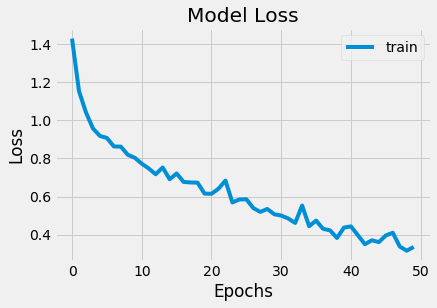

In [17]:
# 顯示訓練集的 Loss 結果
plt.plot(History.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train'])
plt.show()

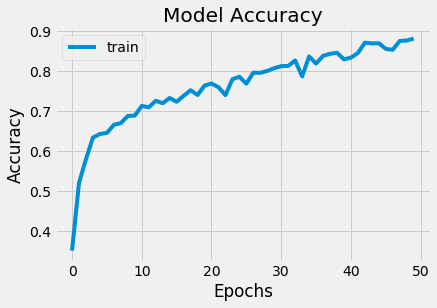

In [18]:
# 顯示訓練集的 Accuracy 結果
plt.plot(History.history['acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train'])
plt.show()

In [19]:
# 輸出預測檔
pred = model.predict(X_test)
pred_digits = np.argmax(pred, axis=1)
sub = pd.DataFrame({'id': id_test, 'flower_class': pred_digits})
sub.to_csv('flower_CNN.csv', index = False)